In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load images

In [3]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031464.959763.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

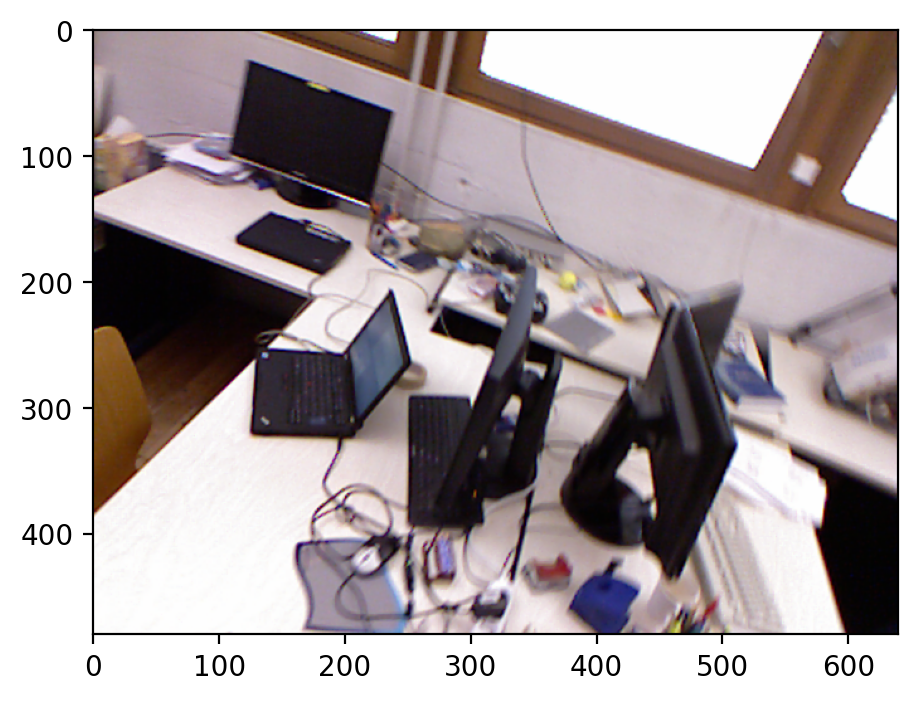

In [4]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

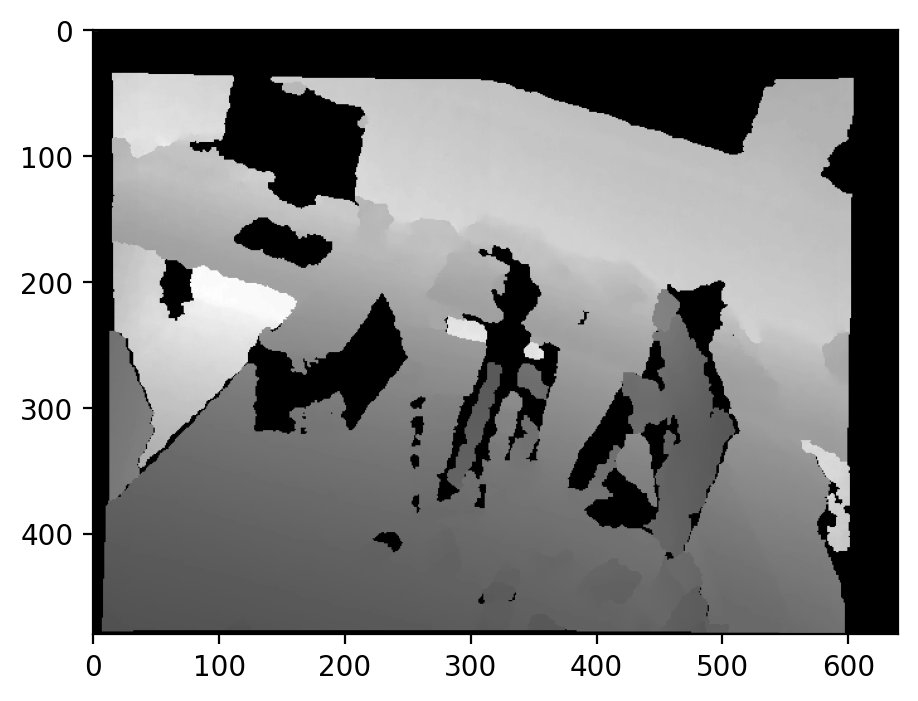

In [5]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [6]:
dataset_params = {'dataset_path': "/media/mikhail/Data3T/tum_rgbd", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 12.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [64]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1 / 5.,
    encoding_sigma=25,
    optimize_positions=False,
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

# SLAM

In [65]:
from imap.slam.imap_data_loader import IMAPDataLoader
from imap.slam.active_sampler import ActiveSampler
from imap.slam.keyframe_validator import KeyframeValidator
from imap.slam.imap_map_builder import IMAPMapBuilder
from imap.slam.imap_tracker import IMAPTracker
from imap.data.tum_frame_loader import TUMFrameLoader
from imap.slam.posed_frame import PosedFrame
import tqdm

In [66]:
dataset_path = "/media/mikhail/Data3T/tum_rgbd"
scene_name = "rgbd_dataset_freiburg1_desk"
association_file_name = "data_association_file.txt"
camera_info = data_module._dataset._camera_info
trainer = pl.Trainer(max_epochs=1, gpus=1, logger=False, weights_summary=None)
map_builder_data_loader = IMAPDataLoader(20, 200, camera_info)

sampler_data_loader = IMAPDataLoader(1, 200, camera_info)
sampler = ActiveSampler(sampler_data_loader, 4, 1)

keyframe_validator_data_loader = IMAPDataLoader(1, 200, camera_info)
keyframe_validator = KeyframeValidator(0.1, 0.9, keyframe_validator_data_loader)
builder = IMAPMapBuilder(trainer, model, map_builder_data_loader, sampler, keyframe_validator)

trainer = pl.Trainer(max_epochs=1, gpus=1, weights_summary=None)
tracker_data_loader = IMAPDataLoader(20, 200, data_module.camera_info())
tracker = IMAPTracker(trainer, tracker_data_loader)



frames = TUMFrameLoader(dataset_path, scene_name, association_file_name, range(200))
frames = [PosedFrame(x, None) for x in frames]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [ ]:
initial_position = frames[0].frame.ground_truth_position.copy()
initial_position[:3, 3] = initial_position[:3, 3] / 10.

tracker.set_initial_position(initial_position)
builder.set_current_frame(frames[0])
frames[0].position = initial_position
builder.step()
tracker.update_model(model)

tracked_positions = []
for frame in tqdm.tqdm(frames):
    frame.position = tracker.track(frame.frame)
    tracked_positions.append(frame.position)
    builder.set_current_frame(frame)
    builder.step()
    tracker.update_model(model)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]


  0%|                                                   | 0/200 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  0%|▏                                          | 1/200 [00:02<06:38,  2.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  1%|▍                                          | 2/200 [00:04<07:02,  2.13s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  2%|▋                                          | 3/200 [00:06<07:21,  2.24s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  2%|▊                                          | 4/200 [00:09<07:41,  2.35s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  2%|█                                          | 5/200 [00:11<07:49,  2.41s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  3%|█▎                                         | 6/200 [00:14<08:14,  2.55s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  4%|█▌                                         | 7/200 [00:17<09:01,  2.81s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  4%|█▋                                         | 8/200 [00:20<09:14,  2.89s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  4%|█▉                                         | 9/200 [00:24<09:43,  3.06s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  5%|██                                        | 10/200 [00:27<09:58,  3.15s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  6%|██▎                                       | 11/200 [00:31<10:15,  3.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  6%|██▌                                       | 12/200 [00:34<10:27,  3.34s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  6%|██▋                                       | 13/200 [00:38<10:37,  3.41s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  7%|██▉                                       | 14/200 [00:42<10:54,  3.52s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  8%|███▏                                      | 15/200 [00:45<10:57,  3.55s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  8%|███▎                                      | 16/200 [00:49<11:02,  3.60s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  8%|███▌                                      | 17/200 [00:53<11:09,  3.66s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


  9%|███▊                                      | 18/200 [00:57<11:16,  3.72s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 10%|███▉                                      | 19/200 [01:00<11:19,  3.76s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 10%|████▏                                     | 20/200 [01:04<11:28,  3.82s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 10%|████▍                                     | 21/200 [01:08<11:34,  3.88s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 11%|████▌                                     | 22/200 [01:12<11:43,  3.95s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 12%|████▊                                     | 23/200 [01:16<11:43,  3.97s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 12%|█████                                     | 24/200 [01:21<11:43,  4.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 12%|█████▎                                    | 25/200 [01:25<11:53,  4.08s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 13%|█████▍                                    | 26/200 [01:29<11:55,  4.11s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 14%|█████▋                                    | 27/200 [01:33<11:57,  4.15s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 14%|█████▉                                    | 28/200 [01:38<12:02,  4.20s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 14%|██████                                    | 29/200 [01:42<12:07,  4.25s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 15%|██████▎                                   | 30/200 [01:46<12:13,  4.32s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 16%|██████▌                                   | 31/200 [01:51<12:20,  4.38s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 16%|██████▋                                   | 32/200 [01:56<12:33,  4.48s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 16%|██████▉                                   | 33/200 [02:00<12:32,  4.50s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 17%|███████▏                                  | 34/200 [02:05<12:34,  4.55s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 18%|███████▎                                  | 35/200 [02:10<12:36,  4.59s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 18%|███████▌                                  | 36/200 [02:14<12:35,  4.61s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 18%|███████▊                                  | 37/200 [02:19<12:35,  4.64s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 19%|███████▉                                  | 38/200 [02:24<12:34,  4.66s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 20%|████████▏                                 | 39/200 [02:28<12:34,  4.69s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 20%|████████▍                                 | 40/200 [02:33<12:33,  4.71s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 20%|████████▌                                 | 41/200 [02:38<12:38,  4.77s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 21%|████████▊                                 | 42/200 [02:43<12:47,  4.86s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 22%|█████████                                 | 43/200 [02:48<12:56,  4.95s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 22%|█████████▏                                | 44/200 [02:54<13:51,  5.33s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 22%|█████████▍                                | 45/200 [03:00<14:14,  5.51s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 23%|█████████▋                                | 46/200 [03:07<14:38,  5.70s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 24%|█████████▊                                | 47/200 [03:12<14:21,  5.63s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 24%|██████████                                | 48/200 [03:17<14:00,  5.53s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 24%|██████████▎                               | 49/200 [03:23<13:44,  5.46s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 25%|██████████▌                               | 50/200 [03:28<13:29,  5.39s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 26%|██████████▋                               | 51/200 [03:33<13:25,  5.41s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 26%|██████████▉                               | 52/200 [03:39<13:28,  5.46s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 26%|███████████▏                              | 53/200 [03:44<13:23,  5.47s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 27%|███████████▎                              | 54/200 [03:50<13:24,  5.51s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 28%|███████████▌                              | 55/200 [03:56<13:23,  5.54s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 28%|███████████▊                              | 56/200 [04:01<13:26,  5.60s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 28%|███████████▉                              | 57/200 [04:07<13:23,  5.62s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 29%|████████████▏                             | 58/200 [04:13<13:25,  5.67s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 30%|████████████▍                             | 59/200 [04:19<13:25,  5.71s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 30%|████████████▌                             | 60/200 [04:24<13:20,  5.72s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 30%|████████████▊                             | 61/200 [04:30<13:21,  5.76s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 31%|█████████████                             | 62/200 [04:36<13:25,  5.83s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 32%|█████████████▏                            | 63/200 [04:42<13:31,  5.92s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 32%|█████████████▍                            | 64/200 [04:48<13:32,  5.97s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 32%|█████████████▋                            | 65/200 [04:55<13:45,  6.11s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 33%|█████████████▊                            | 66/200 [05:01<13:37,  6.10s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 34%|██████████████                            | 67/200 [05:07<13:34,  6.13s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 34%|██████████████▎                           | 68/200 [05:13<13:39,  6.21s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 34%|██████████████▍                           | 69/200 [05:20<13:46,  6.31s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 35%|██████████████▋                           | 70/200 [05:26<13:39,  6.31s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 36%|██████████████▉                           | 71/200 [05:33<13:40,  6.36s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 36%|███████████████                           | 72/200 [05:39<13:32,  6.35s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 36%|███████████████▎                          | 73/200 [05:46<13:26,  6.35s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 37%|███████████████▌                          | 74/200 [05:52<13:29,  6.42s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 38%|███████████████▊                          | 75/200 [05:59<13:27,  6.46s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 38%|███████████████▉                          | 76/200 [06:05<13:28,  6.52s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 38%|████████████████▏                         | 77/200 [06:12<13:33,  6.61s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 39%|████████████████▍                         | 78/200 [06:19<13:23,  6.59s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 40%|████████████████▌                         | 79/200 [06:25<13:20,  6.61s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 40%|████████████████▊                         | 80/200 [06:32<13:27,  6.73s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 40%|█████████████████                         | 81/200 [06:39<13:27,  6.78s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 41%|█████████████████▏                        | 82/200 [06:46<13:22,  6.80s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 42%|█████████████████▍                        | 83/200 [06:53<13:19,  6.83s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 42%|█████████████████▋                        | 84/200 [07:00<13:25,  6.94s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 42%|█████████████████▊                        | 85/200 [07:07<13:29,  7.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 43%|██████████████████                        | 86/200 [07:15<13:27,  7.09s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 44%|██████████████████▎                       | 87/200 [07:22<13:27,  7.15s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 44%|██████████████████▍                       | 88/200 [07:31<14:19,  7.68s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]


 44%|██████████████████▋                       | 89/200 [07:38<14:07,  7.64s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 19it [00:00, ?it/s]

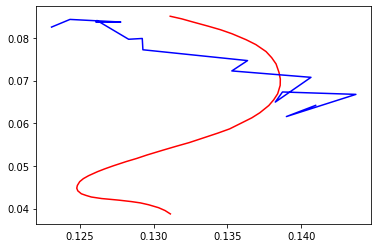

In [58]:
estimated_x = [x.position[0,3] for x in frames if x.position is not None]
estimated_y = [x.position[1,3] for x in frames if x.position is not None]

x_ground_truth = [x.frame.ground_truth_position[0,3] / 10. for x in frames]
y_ground_truth = [x.frame.ground_truth_position[1,3] / 10. for x in frames]

plt.plot(x_ground_truth, y_ground_truth, c='red')
plt.plot(estimated_x, estimated_y, c='blue')
plt.show()

In [50]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
#             go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
#                          y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
#                          z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
#                          mode="lines",
#                          name="errors")
        ]
    )
    fig.show()



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

In [61]:
estimated_trajectory = np.array([x[:3,3] for x in tracked_positions])
estimated_trajectory = np.array([x.position[:3, 3] for x in frames if x.position is not None])
show_trajectories(
                  np.array([x.frame.ground_truth_position[:3,3] / 10 for x in frames]),
                  estimated_trajectory
)